In [1]:
# get a list of ~100k pmids from a file


# select embeddings using the list of pmids


# time

In [20]:

import mysql.connector as mysql
import json

import os
import time
import random
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'  # magic for exporting editable text

In [110]:
db_name = 'test_pubmed'  # db name collisons? https://stackoverflow.com/questions/14011968/user-cant-access-a-database
client_config = {'unix_socket':'/home/brendanchambers/.sql.sock',
                'database': db_name,
                'use_pure': True}  # for python connector
db = mysql.connect(**client_config)


dict_keys(['publications', 'citations'])


In [13]:
L = 1000
test_pmids = data['publications'][:L]





# benchmarking
### (no file lookup)
+ test lookup by directly fetching rows by year instead of file access to year pmid lists
+ this looks great until things get big (presumably because of RAM limits on the BLOB rows?)

In [104]:
year = 1958

K_list = [100,1000,10000, 100000]
records = []
records_baseline = []
records_smallbaseline = []

for K in K_list:

    sql = '''SELECT M.pmid, E.embedding
                FROM metadata as M
                INNER JOIN scibert_mean_embedding as E
                ON M.pmid = E.pmid
                WHERE M.year={} LIMIT {}'''.format(year, K)
    print(sql)

    start_time = time.time()
    cursor = db.cursor()
    cursor.execute(sql)
    output = cursor.fetchall()
    cursor.close()

    end_time = time.time()
    elapsed = end_time - start_time
    records.append(elapsed)
    print("sql join executed in {} s".format(elapsed))
    
### check baseline without any join operation (large table)

    sql = '''SELECT E.pmid, E.embedding
                FROM scibert_mean_embedding as E
                LIMIT {}'''.format(K)
    print(sql)

    start_time = time.time()
    cursor = db.cursor()
    cursor.execute(sql)
    output = cursor.fetchall()
    cursor.close()

    end_time = time.time()
    elapsed = end_time - start_time
    records_baseline.append(elapsed)
    print("sql baseline executed in {} s".format(elapsed))
    
### check baseline without any join operation (small table with WHERE)

    sql = '''SELECT M.pmid, M.year
                FROM metadata as M
                WHERE M.year={}
                LIMIT {}'''.format(year,K)
    print(sql)

    start_time = time.time()
    cursor = db.cursor()
    cursor.execute(sql)
    output = cursor.fetchall()
    cursor.close()

    end_time = time.time()
    elapsed = end_time - start_time
    records_smallbaseline.append(elapsed)
    print("sql baseline executed in {} s".format(elapsed))

SELECT M.pmid, E.embedding
                FROM metadata as M
                INNER JOIN scibert_mean_embedding as E
                ON M.pmid = E.pmid
                WHERE M.year=1958 LIMIT 100
sql join executed in 0.013736724853515625 s
SELECT E.pmid, E.embedding
                FROM scibert_mean_embedding as E
                LIMIT 100
sql baseline executed in 0.01859736442565918 s
SELECT M.pmid, M.year
                FROM metadata as M
                WHERE M.year=1958
                LIMIT 100
sql baseline executed in 0.0020792484283447266 s
SELECT M.pmid, E.embedding
                FROM metadata as M
                INNER JOIN scibert_mean_embedding as E
                ON M.pmid = E.pmid
                WHERE M.year=1958 LIMIT 1000
sql join executed in 0.1535811424255371 s
SELECT E.pmid, E.embedding
                FROM scibert_mean_embedding as E
                LIMIT 1000
sql baseline executed in 0.08496260643005371 s
SELECT M.pmid, M.year
                FROM metadata as M

KeyboardInterrupt: 

Text(0.5, 1.0, 'running time for large SQL JOIN and component operations')

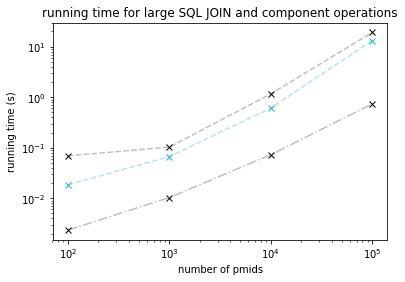

In [92]:
plt.figure()

plt.loglog(K_list, records, color=[0,0.5,0.75],alpha=0.25,linestyle='--')
plt.loglog(K_list, records,'x',color=[0.05, 0.75, 0.75])

plt.loglog(K_list, records_baseline, color='k',alpha=0.25,linestyle='--')
plt.loglog(K_list, records_baseline,'x',color='k')

plt.loglog(K_list, records_smallbaseline, color='k',alpha=0.25,linestyle='-.')
plt.loglog(K_list, records_smallbaseline,'x',color='k')

plt.xlabel('number of pmids')
plt.ylabel('running time (s)')
plt.title('running time for large SQL JOIN and component operations')

# benchmarking
### (with file lookup)

In [113]:
year = 1958

path2dir = '/project2/jevans/brendan/pubmed_data_processing/year_pmids/'
filename = 'pubmed_state_{}'.format(year)
path2pmids = path2dir + filename
with open(path2pmids,'r') as f:
    data = json.load(f)

K_list = [100,1000,10000, 100000]
records = []

for K in K_list:
    
    target_pmids = data['publications'][:K] # for benchmarking
    str_fmt = ', '.join([str(pmid) for pmid in target_pmids])

    sql = '''SELECT E.pmid, E.embedding
                FROM scibert_mean_embedding as E
                WHERE E.pmid IN ({})'''.format(str_fmt)
    #print(sql[:500])

    start_time = time.time()
    cursor = db.cursor()
    cursor.execute(sql)
    output = cursor.fetchall()
    cursor.close()

    end_time = time.time()
    elapsed = end_time - start_time
    records.append(elapsed)
    print("sql join executed in {} s".format(elapsed))
    print()


sql join executed in 0.06144404411315918 s

sql join executed in 0.07614803314208984 s

sql join executed in 0.7716941833496094 s

sql join executed in 11.88233470916748 s



Text(0.5, 1.0, 'running time for large SQL IN lookup')

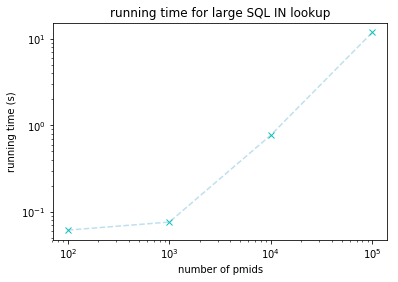

In [114]:
plt.figure()

plt.loglog(K_list, records, color=[0,0.5,0.75],alpha=0.25,linestyle='--')
plt.loglog(K_list, records,'x',color=[0.05, 0.75, 0.75])

plt.xlabel('number of pmids')
plt.ylabel('running time (s)')
plt.title('running time for large SQL IN lookup')

In [109]:
db.close()